In [8]:
import os
import sys
import torch
import pickle
import squarify
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn import metrics
sys.path.insert(0, "../../src")
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import MVTSDataset
from torch.utils.data import DataLoader
from models import CNNModel, TransformerEncoder, CombinedModel
from normalizations import shuffle_tensor_along_time, topological_shuffle, unity_based_normalization, identity_normalization

In [3]:
def make_tree_map(dictionary, title='Relative structure importance for TSS.  ' , save_path=None):

    # load my colors
    with open('/Users/brandonlpanos/my_colors.pkl', 'rb') as f:
        colors = pickle.load(f)
    color_palette = [colors[i] for i in colors.keys()]
    np.random.seed(40)
    np.random.shuffle(color_palette)
    
    data = dictionary.copy()

    if 'cnn_unity_topological' in data.keys():
        data.pop('cnn_unity_topological')

    if 'Unity topological' in data.keys():
        data.pop('Unity topological')

    values = list(data.values())


    total_size = sum(values)
    normalized_values = [v / total_size * 100 for v in values]
    labels = list(data.keys())
    mpl.rcParams['font.size'] = 10
    plt.figure(figsize=(8, 6))
    squarify.plot(sizes=normalized_values, label=labels, alpha=0.8, pad=True, color=color_palette)
    plt.title(title, fontsize=10)
    plt.axis('off')

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return None

In [20]:
# Read CSV file into DataFrame
df = pd.read_csv('../../data/metrics.csv')
df2.head()

,augmentation,tss,auc,hss,bss,accuracy
384,combined_std,0.870671,0.974567,1.0,0.743421,0.934426
385,combined_std,0.749798,0.917004,1.0,0.595573,0.877049
386,combined_std,0.901075,0.987097,1.0,0.801403,0.950820
387,combined_std,0.742778,0.959861,1.0,0.517110,0.877049
388,combined_std,0.879352,0.987584,1.0,0.794891,0.942623


In [6]:
# Convert numeric columns to numeric data type
numeric_columns = ['tss', 'auc', 'hss', 'accuracy']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

# Group the DataFrame by augmentation category
grouped_df = df.groupby('augmentation')

# Loop over the groups and calculate the average metrics and store them in a dictionary
square_dictionary = dict()
for category_name, group in grouped_df:
    if 'cnn' not in category_name: continue # only cnn models
    average_metrics = group[numeric_columns].mean()
    square_dictionary[category_name] = average_metrics

# Store single metric and model
tss_per_model = {key: square_dictionary[key]['tss']
                 for key in square_dictionary.keys()}
auc_per_model = {key: square_dictionary[key]['auc']
                 for key in square_dictionary.keys()}
hss_per_model = {key: square_dictionary[key]['hss']
                 for key in square_dictionary.keys()}
accuracy_per_model = {
    key: square_dictionary[key]['accuracy'] for key in square_dictionary.keys()}

# Map keys to new names for plotting
tss_per_model_names = {'Standard normalization': tss_per_model['combined_std'],
                       'Unity normalization': tss_per_model['combined_unity'],
                       'Standard shuffle': tss_per_model['combined_std_shuffle'],
                       'Unity shuffle': tss_per_model['combined_unity_shuffle'],
                       'Standard topological': tss_per_model['combined_std_topological'],
                       'Unity topological': tss_per_model['combined_unity_topological']}

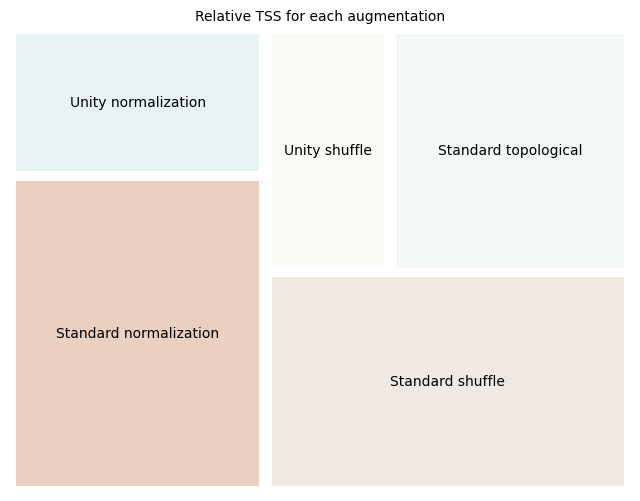

In [5]:
# Make tree map for TSS
make_tree_map(tss_per_model_names, 
              title='Relative TSS for each augmentation',
              save_path=None)

In [6]:
# Relative importance of different structures
intensity = tss_per_model['combined_std_topological']
channel = tss_per_model['combined_std_shuffle'] - tss_per_model['combined_std_topological']
sequence = tss_per_model['combined_std'] - tss_per_model['combined_std_shuffle']
# place in a dictionary 
tss_distribution = {'intensity': intensity, 'channel': channel, 'sequence': sequence * 2}

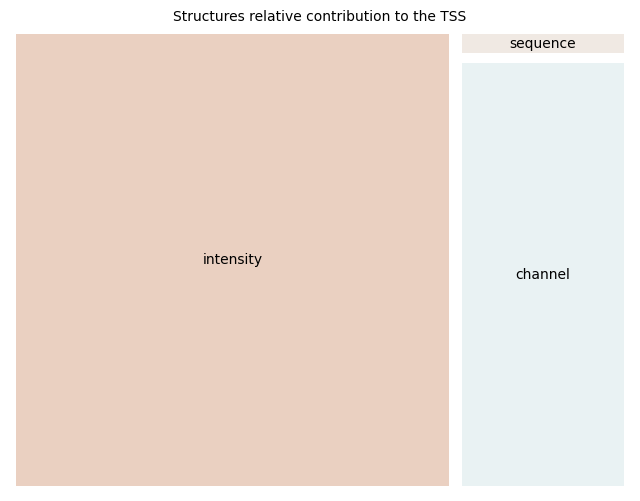

In [7]:
make_tree_map(tss_distribution, title='Structures relative contribution to the TSS',
               save_path=None)